<h1 align=center> Autonomous Research Assistant Agents </h1>


In [1]:
import arxiv
import os

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langgraph.graph import MessagesState, StateGraph, START, END
from typing import Annotated, TypedDict, List, Optional
from typing_extensions import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain.tools import tool


from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [2]:
# from langchain_groq import ChatGroq

# llm = ChatGroq(model_name="deepseek-r1-distill-llama-70b")

# results = llm.invoke("tell me about multi agent types?")
# results

In [3]:
# Initialize LLM (use gpt-4 or gpt-3.5-turbo)
llm2 = ChatOpenAI(model="gpt-4", temperature=0.2)
llm2.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BmQwmvIOF9WDcloZpFW5Ka5v9JLVD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e398f637-3720-4bd8-9070-ba954f90bec1-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

`Excellent progress — you now have:`

✅ Search Agent – finds relevant papers

✅ Filter Agent – selects the most suitable ones

✅ Summarizer Agent – produces readable, concise summaries

In [63]:
## 1. Search Agent

def get_arxiv_papers(topic: str, max_results: int = 5) -> list:
    search = arxiv.Search(
        query=topic,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance
    )

    papers = []
    for result in search.results():
        paper_info = {
            "title": result.title,
            "authors": [author.name for author in result.authors],
            "summary": result.summary.strip().replace("\n", " "),
            "url": result.entry_id,
            "pdf_url": result.pdf_url,
            "published": str(result.published.date()),
            "year": result.published.year
        }
        papers.append(paper_info)
    return papers

In [43]:
import textwrap

user_topic = "Large Language Models in Healthcare"
papers = get_arxiv_papers(user_topic)


wrapper = textwrap.TextWrapper(width=100)

for i, paper in enumerate(papers):
    print(f"📄 Paper {i+1}: {paper['title']}")
    print(f"👨‍🔬 Authors: {', '.join(paper['authors'])}")
    print(f"🗓️ Published: {paper['published']}")
    print(f"🔗 URL: {paper['url']}")
    print("📄 Abstract:")
    print(wrapper.fill(paper['summary'][:500]) + "...\n")

C:\Users\44787\AppData\Local\Temp\ipykernel_24804\201622925.py:9: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


📄 Paper 1: Aligning Large Language Models with Healthcare Stakeholders: A Pathway to Trustworthy AI Integration
👨‍🔬 Authors: Kexin Ding, Mu Zhou, Akshay Chaudhari, Shaoting Zhang, Dimitris N. Metaxas
🗓️ Published: 2025-05-02
🔗 URL: http://arxiv.org/abs/2505.02848v1
📄 Abstract:
The wide exploration of large language models (LLMs) raises the awareness of alignment between
healthcare stakeholder preferences and model outputs. This alignment becomes a crucial foundation to
empower the healthcare workflow effectively, safely, and responsibly. Yet the varying behaviors of
LLMs may not always match with healthcare stakeholders' knowledge, demands, and values. To enable a
human-AI alignment, healthcare stakeholders will need to perform essential roles in guiding and
enhancing...

📄 Paper 2: An Analysis on Large Language Models in Healthcare: A Case Study of BioBERT
👨‍🔬 Authors: Shyni Sharaf, V. S. Anoop
🗓️ Published: 2023-10-11
🔗 URL: http://arxiv.org/abs/2310.07282v2
📄 Abstract:
This paper co

In [44]:
len(papers)

5

In [62]:
## 2.Filter Agent

filter_prompt = PromptTemplate(
    input_variables=["topic", "papers"],
    template="""
        Given the topic: "{topic}"

        Here are 5 research papers (title and abstract):
        {papers}

        From these, select the top 3 papers that are **most relevant and recent** to the topic.
        Output them in a JSON format like:
        [
          {{ "title": "...", "summary": "...", "year": 2023, "why_selected": "..." }},
          ...
        ]
    """
)

filter_chain = filter_prompt | llm2

filtered = filter_chain.invoke({
    "topic": user_topic,
    "papers": "\n\n".join([f"Title: {p['title']}\nAbstract: {p['summary']}" for p in papers])
})

In [66]:
import json

# Step 1: Extract JSON string from the content
json_str = filtered.content

# Step 2: Parse JSON string into Python list
filtered_papers = json.loads(json_str)

# Step 3: Now you can iterate over papers and access dict keys
for i, paper in enumerate(filtered_papers):
    print(f"📄 Paper {i+1}: {paper['title']}")
    print(f"👨‍🔬 Authors: N/A (not included here)")
    print(f"🗓️ Year: {paper['year']}")
    print(f"📌 Why Selected: {paper['why_selected']}")
    print(f"📄 Summary: {wrapper.fill(paper['summary'][:500])}...\n")


📄 Paper 1: Aligning Large Language Models with Healthcare Stakeholders: A Pathway to Trustworthy AI Integration
👨‍🔬 Authors: N/A (not included here)
🗓️ Year: 2023
📌 Why Selected: This paper is selected because it discusses the alignment between large language models and healthcare stakeholders, which is a crucial aspect of integrating AI in healthcare. It also provides an outlook on enhancing this alignment, making it highly relevant to the topic.
📄 Summary: The wide exploration of large language models (LLMs) raises the awareness of alignment between
healthcare stakeholder preferences and model outputs. This alignment becomes a crucial foundation to
empower the healthcare workflow effectively, safely, and responsibly. Yet the varying behaviors of
LLMs may not always match with healthcare stakeholders' knowledge, demands, and values. To enable a
human-AI alignment, healthcare stakeholders will need to perform essential roles in guiding and
enhancing...

📄 Paper 2: An Analysis on Large 

In [67]:
## 3. Summarization Agent

summary_prompt = PromptTemplate(
    input_variables=["title", "abstract"],
    template="""
        You are a research assistant. Given the title and abstract of a paper, write a clear and concise summary (~100 words) in plain English.

        Title: {title}
        Abstract: {abstract}

        Summary:
    """
)

summary_chain = summary_prompt | llm2

summaries = []
for paper in filtered_papers:
    summary = summary_chain.invoke({
        "title": paper["title"],
        "abstract": paper["summary"]
    })
    summaries.append({
        "title": paper["title"],
        "summary": summary,
        "link": paper.get("url")
    })


In [75]:
for i, paper in enumerate(papers):
    title = paper["title"]
    summary = paper["summary"]
    link = paper.get("link", "No link provided")

    print(f"📄 Paper {i+1}: {title}")
    print(f"🔗 Link: {link}")
    print(f"📄 Summary: {wrapper.fill(summary[:500])}...\n")


📄 Paper 1: Aligning Large Language Models with Healthcare Stakeholders: A Pathway to Trustworthy AI Integration
🔗 Link: No link provided
📄 Summary: The wide exploration of large language models (LLMs) raises the awareness of alignment between
healthcare stakeholder preferences and model outputs. This alignment becomes a crucial foundation to
empower the healthcare workflow effectively, safely, and responsibly. Yet the varying behaviors of
LLMs may not always match with healthcare stakeholders' knowledge, demands, and values. To enable a
human-AI alignment, healthcare stakeholders will need to perform essential roles in guiding and
enhancing...

📄 Paper 2: An Analysis on Large Language Models in Healthcare: A Case Study of BioBERT
🔗 Link: No link provided
📄 Summary: This paper conducts a comprehensive investigation into applying large language models, particularly
on BioBERT, in healthcare. It begins with thoroughly examining previous natural language processing
(NLP) approaches in heal

In [78]:
from fpdf import FPDF

def save_summary_pdf(papers, filename="summary.pdf"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    
    for i, paper in enumerate(papers):
        pdf.multi_cell(0, 10, f"{i+1}. {paper['title']}", align='L')
        pdf.multi_cell(0, 10, paper['summary'].content if hasattr(paper['summary'], 'content') else str(paper['summary']))
        pdf.ln(10)
    
    pdf.output(filename)


In [79]:
save_summary_pdf(summaries, f"{user_topic}+.pdf")

In [24]:
# LangChain prompt template
summary_prompt = PromptTemplate.from_template("""
You are an AI research assistant. Read the abstract below and summarize the key points.

Abstract:
"{abstract}"

Summarize in 3 bullet points.
""")


summarizer_chain = summary_prompt | llm2

In [29]:
summarized_papers = []

for paper in papers:
    abstract = paper["summary"]
    summary = summarizer_chain.invoke({"abstract": abstract})

    paper_with_summary = {
        **paper,
        "summary_bullets": summary.content
    }
    summarized_papers.append(paper_with_summary)

In [30]:
for i, paper in enumerate(summarized_papers):
    print(f"📘 Paper {i+1}: {paper['title']}")
    print(f"📝 Summary:\n{paper['summary_bullets']}")
    print(f"🔗 URL: {paper['url']}\n{'='*80}\n")

📘 Paper 1: Aligning Large Language Models with Healthcare Stakeholders: A Pathway to Trustworthy AI Integration
📝 Summary:
- The use of large language models (LLMs) in healthcare requires alignment with the preferences, knowledge, and values of healthcare stakeholders to ensure effective, safe, and responsible workflows.
- Healthcare professionals need to be involved in all stages of LLM adoption, including data curation, model training, and inference, to ensure human-AI alignment.
- The review discusses methods to improve alignment between healthcare stakeholders and LLMs, emphasizing the need for better integration of healthcare knowledge, task understanding, and human guidance to build trustworthy healthcare applications.
🔗 URL: http://arxiv.org/abs/2505.02848v1

📘 Paper 2: An Analysis on Large Language Models in Healthcare: A Case Study of BioBERT
📝 Summary:
- The paper investigates the application of large language models, specifically BioBERT, in healthcare, discussing its suitab

In [ ]:
import json

with open(f"{topic}.json", "w") as f:
    json.dump(summarized_papers, f)

`Define Shared State`

- LangGraph uses a shared dictionary-like state that agents can read/write.
- Define what your state will contain.


In [9]:
class ResearchState(TypedDict):
    topic: str
    papers: Optional[List[dict]]
    summaries: Optional[List[dict]]

In [10]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [11]:
def make_system_prompt(instruction: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [12]:
@tool
def arxiv1(topic: str, max_results: int = 2) -> str:
    """Fetches relevant paper abstracts from arXiv based on a topic."""
    papers = get_arxiv_papers(topic, max_results)
    output = ""
    for i, paper in enumerate(papers):
        output += f"\n[{i+1}] {paper['title']} ({paper['published']})\n"
        output += f"Authors: {', '.join(paper['authors'])}\n"
        output += f"Abstract: {paper['summary'][:500]}...\n"
        output += f"URL: {paper['url']}\n\n"
    return output

In [13]:
research_agent = create_react_agent(
    llm2,
    tools=[arxiv1],
    prompt=make_system_prompt(
        "You can only do research. You are working with a summarizer colleague."
    ),
)

In [14]:
@tool
def summarize_abstract(abstract: str) -> str:
    """
    Summarizes a research paper abstract into 3 concise bullet points.
    """

    summary_prompt = PromptTemplate.from_template("""
    You are an AI research assistant. Read the abstract below and summarize the key points.

    Abstract:
    "{abstract}"

    Summarize in 3 bullet points.
    """)

    response = summary_prompt | llm2
    return response

In [15]:
summarized_agent = create_react_agent(
    llm2,
    tools=[summarize_abstract],
    prompt=make_system_prompt(
        "You can only summarize abstracts. Your teammate provides the abstracts."
    )
)

In [16]:
def research_node(state: MessagesState) -> Command[Literal["summarizer", END]]:

    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "summarizer")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher")

    return Command(update={"messages": result["messages"]}, goto=goto)

In [17]:
def summarizer_node(state: MessagesState) -> Command[Literal["researcher", END]]:

    result = summarized_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="summarizer")

    return Command(update={"messages": result["messages"]}, goto=goto)

In [18]:
workflow = StateGraph(MessagesState)

workflow.add_node("researcher", research_node)
workflow.add_node("summarizer", summarizer_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

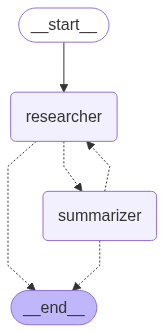

In [19]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
app.invoke({"messages": [("user", "get the research paper in transformer")], })

C:\Users\44787\AppData\Local\Temp\ipykernel_24804\3121392185.py:9: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


{'messages': [HumanMessage(content='get the research paper in transformer', additional_kwargs={}, response_metadata={}, id='07c6511d-f92b-47b2-a42c-b963a728f083'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ao1MjJ7fSCGPvtbAkykWBiEz', 'function': {'arguments': '{\n  "topic": "transformer",\n  "max_results": 5\n}', 'name': 'arxiv1'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 173, 'total_tokens': 198, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BmQxVpkjNxxJZJkROoapL1TrhbeyG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0059b588-16dc-4c61-a3d3-87e3866b58c4-0', tool_calls=[{'name': 'arxiv1', 'args': {'topic': 'transfor